# 3일차과제
목표변수 FAT를 예측하기 위한 새로운 파생변수(BMI 등)를  생성하여 회귀분석을 실시하고 결과를 해석하라.(BMI 계산 시, WEIGHT는 파운드(1lb0.45kg), HEIGHT는 인치(1inch2.54cm)이므로 변환하여 사용)
데이터 : 체질검사.CSV(변수: 14, 자료 수: 252개)

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import scale
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
ds_fa = pd.read_csv('./Downloads/week4day1/체질검사.csv',engine='python')
ds_fa.head()
#관측치 252개, 종속변수 FAT 1개, 최초설명변수 13개
#WEIGHT=몸무게(lbs), HEIGHT=키(inches),
#그 외는 둘레는 cm 단위 
#모두 연속형 변수
#body fat data
#http://staff.pubhealth.ku.dk/~tag/Teaching/share/data/Bodyfat.html
#252명의 성인남자 data


,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [4]:
ds_fa.info()
#결측치 없음, 나이는 정수형, 그 외 변수는 실수로 연속형

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 14 columns):
FAT        252 non-null float64
AGE        252 non-null int64
WEIGHT     252 non-null float64
HEIGHT     252 non-null float64
NECK       252 non-null float64
CHEST      252 non-null float64
ABDOMEN    252 non-null float64
HIP        252 non-null float64
THIGH      252 non-null float64
KNEE       252 non-null float64
ANKLE      252 non-null float64
BICEPS     252 non-null float64
FOREARM    252 non-null float64
WRIST      252 non-null float64
dtypes: float64(13), int64(1)
memory usage: 27.6 KB


# BMI 계산

In [5]:
ds_fa['BMI']=(ds_fa['WEIGHT']*0.45)/(ds_fa['HEIGHT']*2.54/100)**2

In [6]:
ds_fa.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.523870
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.082595
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.422478
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.838617
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.293165


In [7]:
ds_fa_describe=ds_fa.describe()
ds_fa_describe.round(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
count,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000
mean,19.151,44.885,178.924,70.149,37.992,100.824,92.556,99.905,59.406,38.590,23.102,32.273,28.664,18.230,25.737
std,8.369,12.602,29.389,3.663,2.431,8.430,10.783,7.164,5.250,2.412,1.695,3.021,2.021,0.934,9.483
min,0.000,22.000,118.500,29.500,31.100,79.300,69.400,85.000,47.200,33.000,19.100,24.800,21.000,15.800,17.875
25%,12.475,35.750,159.000,68.250,36.400,94.350,84.575,95.500,56.000,36.975,22.000,30.200,27.300,17.600,22.853
50%,19.200,43.000,176.500,70.000,38.000,99.650,90.950,99.300,59.000,38.500,22.800,32.050,28.700,18.300,24.896
75%,25.300,54.000,197.000,72.250,39.425,105.375,99.325,103.525,62.350,39.925,24.000,34.325,30.000,18.800,27.118
max,47.500,81.000,363.150,77.750,51.200,136.200,148.100,147.700,87.300,49.100,33.900,45.000,34.900,21.400,164.307


In [8]:
ds_scale=scale(ds_fa)
ds_scale=pd.DataFrame(ds_scale,columns=ds_fa.columns)
ds_scale.head()
ds_scale_describe=ds_scale.describe()
ds_scale_describe.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
count,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000
mean,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000
std,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002
min,-2.293,-1.820,-2.060,-11.120,-2.841,-2.558,-2.152,-2.085,-2.330,-2.323,-2.366,-2.479,-3.800,-2.608,-0.831
25%,-0.799,-0.726,-0.679,-0.519,-0.656,-0.769,-0.742,-0.616,-0.650,-0.671,-0.652,-0.688,-0.676,-0.676,-0.305
50%,0.006,-0.150,-0.083,-0.041,0.003,-0.140,-0.149,-0.085,-0.077,-0.038,-0.179,-0.074,0.018,0.075,-0.089
75%,0.736,0.725,0.616,0.575,0.591,0.541,0.629,0.506,0.562,0.554,0.531,0.680,0.663,0.612,0.146
max,3.394,2.872,6.281,2.079,5.444,4.205,5.161,6.685,5.324,4.366,6.383,4.221,3.092,3.403,14.642


# 이상치 판단 및 제거 

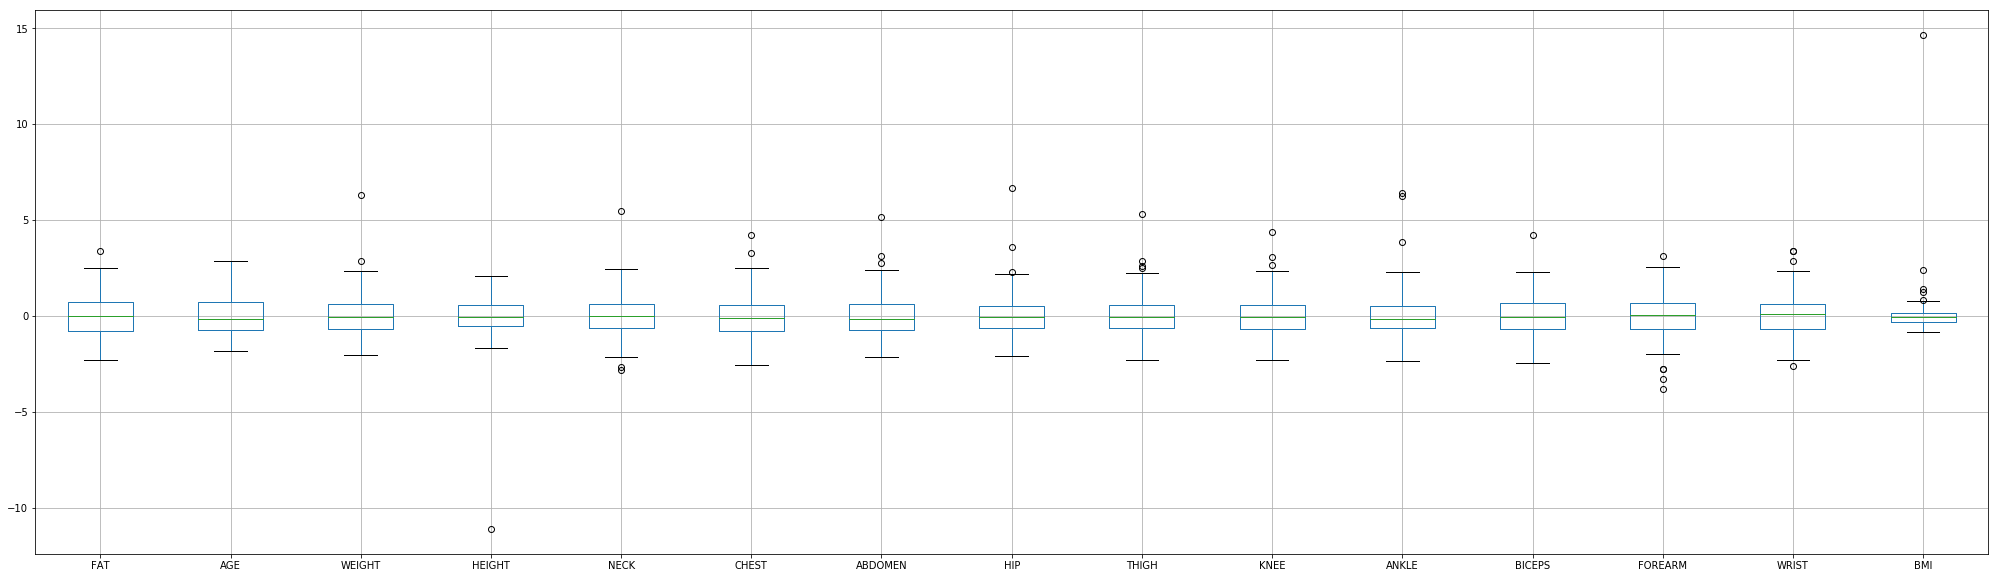

In [11]:
ds_scale.boxplot(figsize=(35,10))
#scale변수들의 boxplot을 보면 일부 이상치로 의심되는 data들이 발견
#밑의 4분위수, IQR을 이용한 UCL, LCL과 실제 박스플랏이 다소 차이남
#보통 UCL, LCL 중 한 쪽으로만 data가 퍼져 있음
#실제로 변수 순서대로 이상치를 제거하면서 뒤의 변수 기준 이상치가 제거되기도 함

In [12]:
#원본 data 생성
ds_fa_ori=ds_fa

UCL= 81.375
LCL= 8.375
max= 81
min= 22


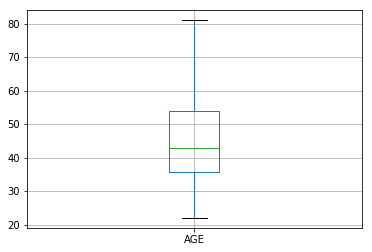

In [13]:
ds_fa.boxplot(column="AGE")
q3, q1 = np.percentile(ds_fa["AGE"], [75, 25])
UCL=q3+1.5*(q3-q1)
print("UCL=", UCL)
LCL=q1-1.5*(q3-q1)
print("LCL=", LCL)
print("max=",ds_fa["AGE"].max())
print("min=",ds_fa["AGE"].min())
#나이의 이상치는 보이지 않음

UCL= 254.0
LCL= 102.0
max= 363.15
min= 118.5


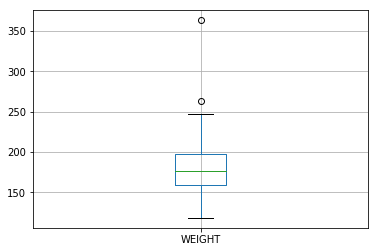

In [14]:
ds_fa.boxplot(column="WEIGHT")
q3, q1 = np.percentile(ds_fa["WEIGHT"], [75, 25])
UCL=q3+1.5*(q3-q1)
print("UCL=", UCL)
LCL=q1-1.5*(q3-q1)
print("LCL=", LCL)
print("max=",ds_fa["WEIGHT"].max())
print("min=",ds_fa["WEIGHT"].min())
#UCL 254파운드는 약 115kg으로 
#2개의 관측치 363파운드는 약 163kg , 262파운드는 약 118kg로 
#물리적으로 가능하지만 주 분석대상인 일반적인 체형을 벗어나는 특이케이스라 볼 수 있음
#분석이 잘 맞지 않을 확률이 높은 특이체형이라 제거

In [15]:
ds_fa = ds_fa[ds_fa["WEIGHT"] < UCL]
#WEIGHT변수에서 UCL 254 초과 관측치 제거

UCL= 78.25
LCL= 62.25
max= 77.75
min= 29.5


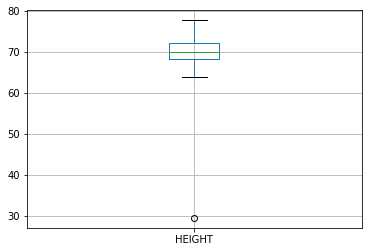

In [16]:
ds_fa.boxplot(column="HEIGHT")
q3, q1 = np.percentile(ds_fa["HEIGHT"], [75, 25])
UCL=q3+1.5*(q3-q1)
print("UCL=", UCL)
LCL=q1-1.5*(q3-q1)
print("LCL=", LCL)
print("max=",ds_fa["HEIGHT"].max())
print("min=",ds_fa["HEIGHT"].min())
# LCL 62.25인치는 약 158cm
# 1개의 관측치 29.5인치는 약 75cm
# AGE의 min은 22로 성인의 키가 75cm면 비정상적이라 판단해 제거

In [17]:
ds_fa = ds_fa[ds_fa["HEIGHT"] > LCL]
#HEIGHT변수에서 LCL 62.25 미만 관측치 제거

UCL= 43.9
LCL= 31.9
max= 43.9
min= 31.1


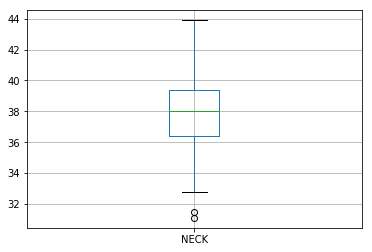

In [18]:
ds_fa.boxplot(column="NECK")
q3, q1 = np.percentile(ds_fa["NECK"], [75, 25])
UCL=q3+1.5*(q3-q1)
print("UCL=", UCL)
LCL=q1-1.5*(q3-q1)
print("LCL=", LCL)
print("max=",ds_fa["NECK"].max())
print("min=",ds_fa["NECK"].min())
# LCL = 31.9cm
# 32cm 미만의 값들 매우 비정상적이라 판단
# IQR대비 멀리 떨어져 있음
# 31.1cm, 31.5cm의 해당 수치를 이상치라 판단

In [19]:
ds_fa = ds_fa[ds_fa["NECK"] > LCL]
#NECK 변수에서 LCL 31.9 이하 관측치 제거

UCL= 121.5
LCL= 78.30000000000001
max= 121.6
min= 79.3


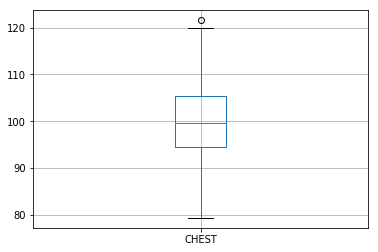

In [20]:
ds_fa.boxplot(column="CHEST")
q3, q1 = np.percentile(ds_fa["CHEST"], [75, 25])
UCL=q3+1.5*(q3-q1)
print("UCL=", UCL)
LCL=q1-1.5*(q3-q1)
print("LCL=", LCL)
print("max=",ds_fa["CHEST"].max())
print("min=",ds_fa["CHEST"].min())
# UCL = 121.5cm
# UCL을 초과하는 121.6cm이지만 차이가 미미
# 따라서 제거하지 않음

UCL= 121.05000000000001
LCL= 62.649999999999984
max= 122.1
min= 69.4


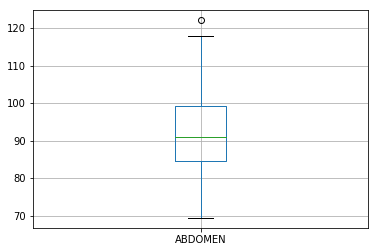

In [21]:
ds_fa.boxplot(column="ABDOMEN")
q3, q1 = np.percentile(ds_fa["ABDOMEN"], [75, 25])
UCL=q3+1.5*(q3-q1)
print("UCL=", UCL)
LCL=q1-1.5*(q3-q1)
print("LCL=", LCL)
print("max=",ds_fa["ABDOMEN"].max())
print("min=",ds_fa["ABDOMEN"].min())
# UCL = 121.1cm
# UCL을 초과하는 122.1cm의 이상치 의심 data지만 IQR대비 차이가 미미
# 따라서 제거하지 않음

UCL= 114.62500000000001
LCL= 84.02499999999999
max= 116.1
min= 85.0


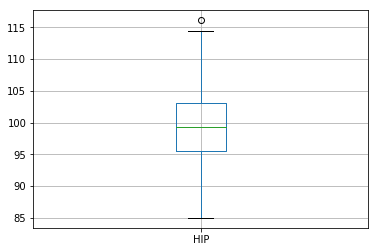

In [22]:
ds_fa.boxplot(column="HIP")
q3, q1 = np.percentile(ds_fa["HIP"], [75, 25])
UCL=q3+1.5*(q3-q1)
print("UCL=", UCL)
LCL=q1-1.5*(q3-q1)
print("LCL=", LCL)
print("max=",ds_fa["HIP"].max())
print("min=",ds_fa["HIP"].min())
# UCL = 114.6cm
# UCL을 초과하는 116.1cm 이상치 의심 data지만 IQR대비 차이가 미미
# 따라서 제거하지 않음

UCL= 71.42500000000001
LCL= 46.82499999999999
max= 74.4
min= 47.2


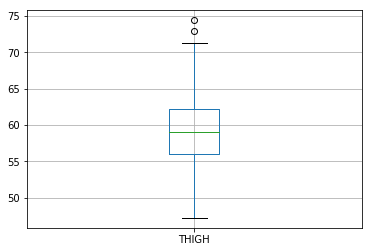

In [23]:
ds_fa.boxplot(column="THIGH")
q3, q1 = np.percentile(ds_fa["THIGH"], [75, 25])
UCL=q3+1.5*(q3-q1)
print("UCL=", UCL)
LCL=q1-1.5*(q3-q1)
print("LCL=", LCL)
print("max=",ds_fa["THIGH"].max())
print("min=",ds_fa["THIGH"].min())
# UCL = 71.6cm
# UCL을 초과하는 74.4cm, 72.5cm이상치 의심 data
# 74.4cm의 data는 IQR대비 멀리 떨어져 있어 이상치로 보고 제거

In [24]:
ds_fa = ds_fa[ds_fa["THIGH"] < 74]
#THIGH 변수에서 74이상 관측치 제거

UCL= 44.300000000000004
LCL= 32.49999999999999
max= 46.0
min= 33.0


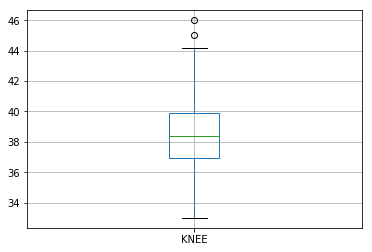

In [25]:
ds_fa.boxplot(column="KNEE")
q3, q1 = np.percentile(ds_fa["KNEE"], [75, 25])
UCL=q3+1.5*(q3-q1)
print("UCL=", UCL)
LCL=q1-1.5*(q3-q1)
print("LCL=", LCL)
print("max=",ds_fa["KNEE"].max())
print("min=",ds_fa["KNEE"].min())
# UCL = 44.3cm
# UCL을 초과하는 45cm, 46cm의 이상치 의심 data
# 46cm의 data는 IQR대비 멀리 떨어져 있어 이상치로 보고 제거

In [26]:
ds_fa = ds_fa[ds_fa["KNEE"] < 45.5]
#KNEE 변수에서 45.5이상 관측치 제거

UCL= 26.749999999999996
LCL= 19.150000000000002
max= 33.9
min= 19.1


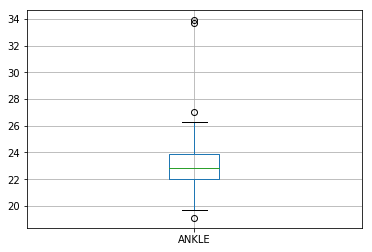

In [27]:
ds_fa.boxplot(column="ANKLE")
q3, q1 = np.percentile(ds_fa["ANKLE"], [75, 25])
UCL=q3+1.5*(q3-q1)
print("UCL=", UCL)
LCL=q1-1.5*(q3-q1)
print("LCL=", LCL)
print("max=",ds_fa["ANKLE"].max())
print("min=",ds_fa["ANKLE"].min())
# UCL = 26.7cm
# UCL을 초과하는 33.7cm, 33.9cm, 27cm의 이상치 의심 data
# 33.7cm, 33.9cm의 data는 IQR대비 멀리 떨어져 있어 이상치로 보고 제거
# min인 19.1cm는 LCL과 차이가 미미하므로 제거하지 않음

In [28]:
ds_fa = ds_fa[ds_fa["ANKLE"] < 28]
#ANKLE 변수에서 28이상 관측치 제거

UCL= 40.20000000000001
LCL= 24.199999999999996
max= 39.1
min= 24.8


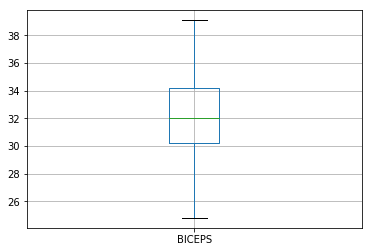

In [29]:
ds_fa.boxplot(column="BICEPS")
q3, q1 = np.percentile(ds_fa["BICEPS"], [75, 25])
UCL=q3+1.5*(q3-q1)
print("UCL=", UCL)
LCL=q1-1.5*(q3-q1)
print("LCL=", LCL)
print("max=",ds_fa["BICEPS"].max())
print("min=",ds_fa["BICEPS"].min())
# 특별한 이상치 없음

UCL= 34.05
LCL= 23.25
max= 34.9
min= 21.0


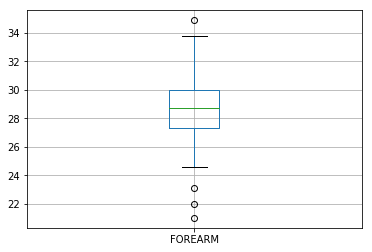

In [30]:
ds_fa.boxplot(column="FOREARM")
q3, q1 = np.percentile(ds_fa["FOREARM"], [75, 25])
UCL=q3+1.5*(q3-q1)
print("UCL=", UCL)
LCL=q1-1.5*(q3-q1)
print("LCL=", LCL)
print("max=",ds_fa["FOREARM"].max())
print("min=",ds_fa["FOREARM"].min())
# max인 34.9cm는 IQR대비 이상치로 판단하기 어려움
# min인 21cm와 22cm, 23.1cm가 박스플랏을 벗어나나 23.1cm는 LCL과 큰 차이가 없어 이상치로 판단하기 어려움
# 따라서 22cm와 21cm를 제거

In [31]:
ds_fa = ds_fa[ds_fa["FOREARM"] > 22.5]
#FOREARM 변수에서 22.5이하 관측치 제거

UCL= 20.6
LCL= 15.800000000000002
max= 20.9
min= 16.3


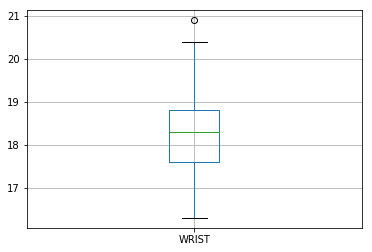

In [32]:
ds_fa.boxplot(column="WRIST")
q3, q1 = np.percentile(ds_fa["WRIST"], [75, 25])
UCL=q3+1.5*(q3-q1)
print("UCL=", UCL)
LCL=q1-1.5*(q3-q1)
print("LCL=", LCL)
print("max=",ds_fa["WRIST"].max())
print("min=",ds_fa["WRIST"].min())
# max가 UCL과 IQR대비 차이가 미미함
# 따라서 제거하지 않음

UCL= 33.2101658296765
LCL= 16.63908684103663
max= 37.29316540664331
min= 17.874981684219424


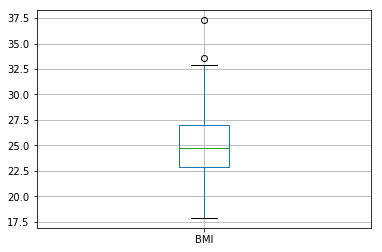

In [33]:
ds_fa.boxplot(column="BMI")
q3, q1 = np.percentile(ds_fa["BMI"], [75, 25])
UCL=q3+1.5*(q3-q1)
print("UCL=", UCL)
LCL=q1-1.5*(q3-q1)
print("LCL=", LCL)
print("max=",ds_fa["BMI"].max())
print("min=",ds_fa["BMI"].min())
# max인 37.3이 물리적으로 가능한 BMI라고 볼 수도 있지만
# IQR대비 멀리 떨어져 있으므로 이상치로 판단하고 제거

In [34]:
ds_fa = ds_fa[ds_fa["BMI"] < 37]
#BMI 변수에서 37이상 관측치 제거

In [35]:
ds_fa.info()
#252개의 관측치에서 242개로 총 12개의 관측치가 제거

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 1 to 251
Data columns (total 15 columns):
FAT        240 non-null float64
AGE        240 non-null int64
WEIGHT     240 non-null float64
HEIGHT     240 non-null float64
NECK       240 non-null float64
CHEST      240 non-null float64
ABDOMEN    240 non-null float64
HIP        240 non-null float64
THIGH      240 non-null float64
KNEE       240 non-null float64
ANKLE      240 non-null float64
BICEPS     240 non-null float64
FOREARM    240 non-null float64
WRIST      240 non-null float64
BMI        240 non-null float64
dtypes: float64(14), int64(1)
memory usage: 30.0 KB


# 이상치 제거 완료

In [36]:
ds_fa.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.082595
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.422478
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.838617
5,24.2,40,202.25,70.00,38.5,106.5,100.9,106.2,63.5,39.9,22.6,35.1,30.6,19.0,28.789726
6,23.3,52,167.00,67.75,37.5,102.7,91.0,98.9,57.1,36.7,22.3,31.6,27.5,17.9,25.377156


In [37]:
ds_fa_y=ds_fa["FAT"]
ds_fa_x=ds_fa.drop("FAT", axis=1, inplace=False)
print("목표변수 데이터 크기:{}".format(ds_fa_y.shape))
print("설명변수 데이터 크기:{}".format(ds_fa_x.shape))
#관측치 240개, 설명변수 14개(BMI포함), 목표변수 FAT 

목표변수 데이터 크기:(240,)
설명변수 데이터 크기:(240, 14)


In [38]:
ds_fa_x_const=sm.add_constant(ds_fa_x)
ds_fa_x_const.head()
#회귀분석을 위한 절편 생성

,const,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
1,1.0,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.082595
2,1.0,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.422478
3,1.0,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.838617
5,1.0,40,202.25,70.00,38.5,106.5,100.9,106.2,63.5,39.9,22.6,35.1,30.6,19.0,28.789726
6,1.0,52,167.00,67.75,37.5,102.7,91.0,98.9,57.1,36.7,22.3,31.6,27.5,17.9,25.377156


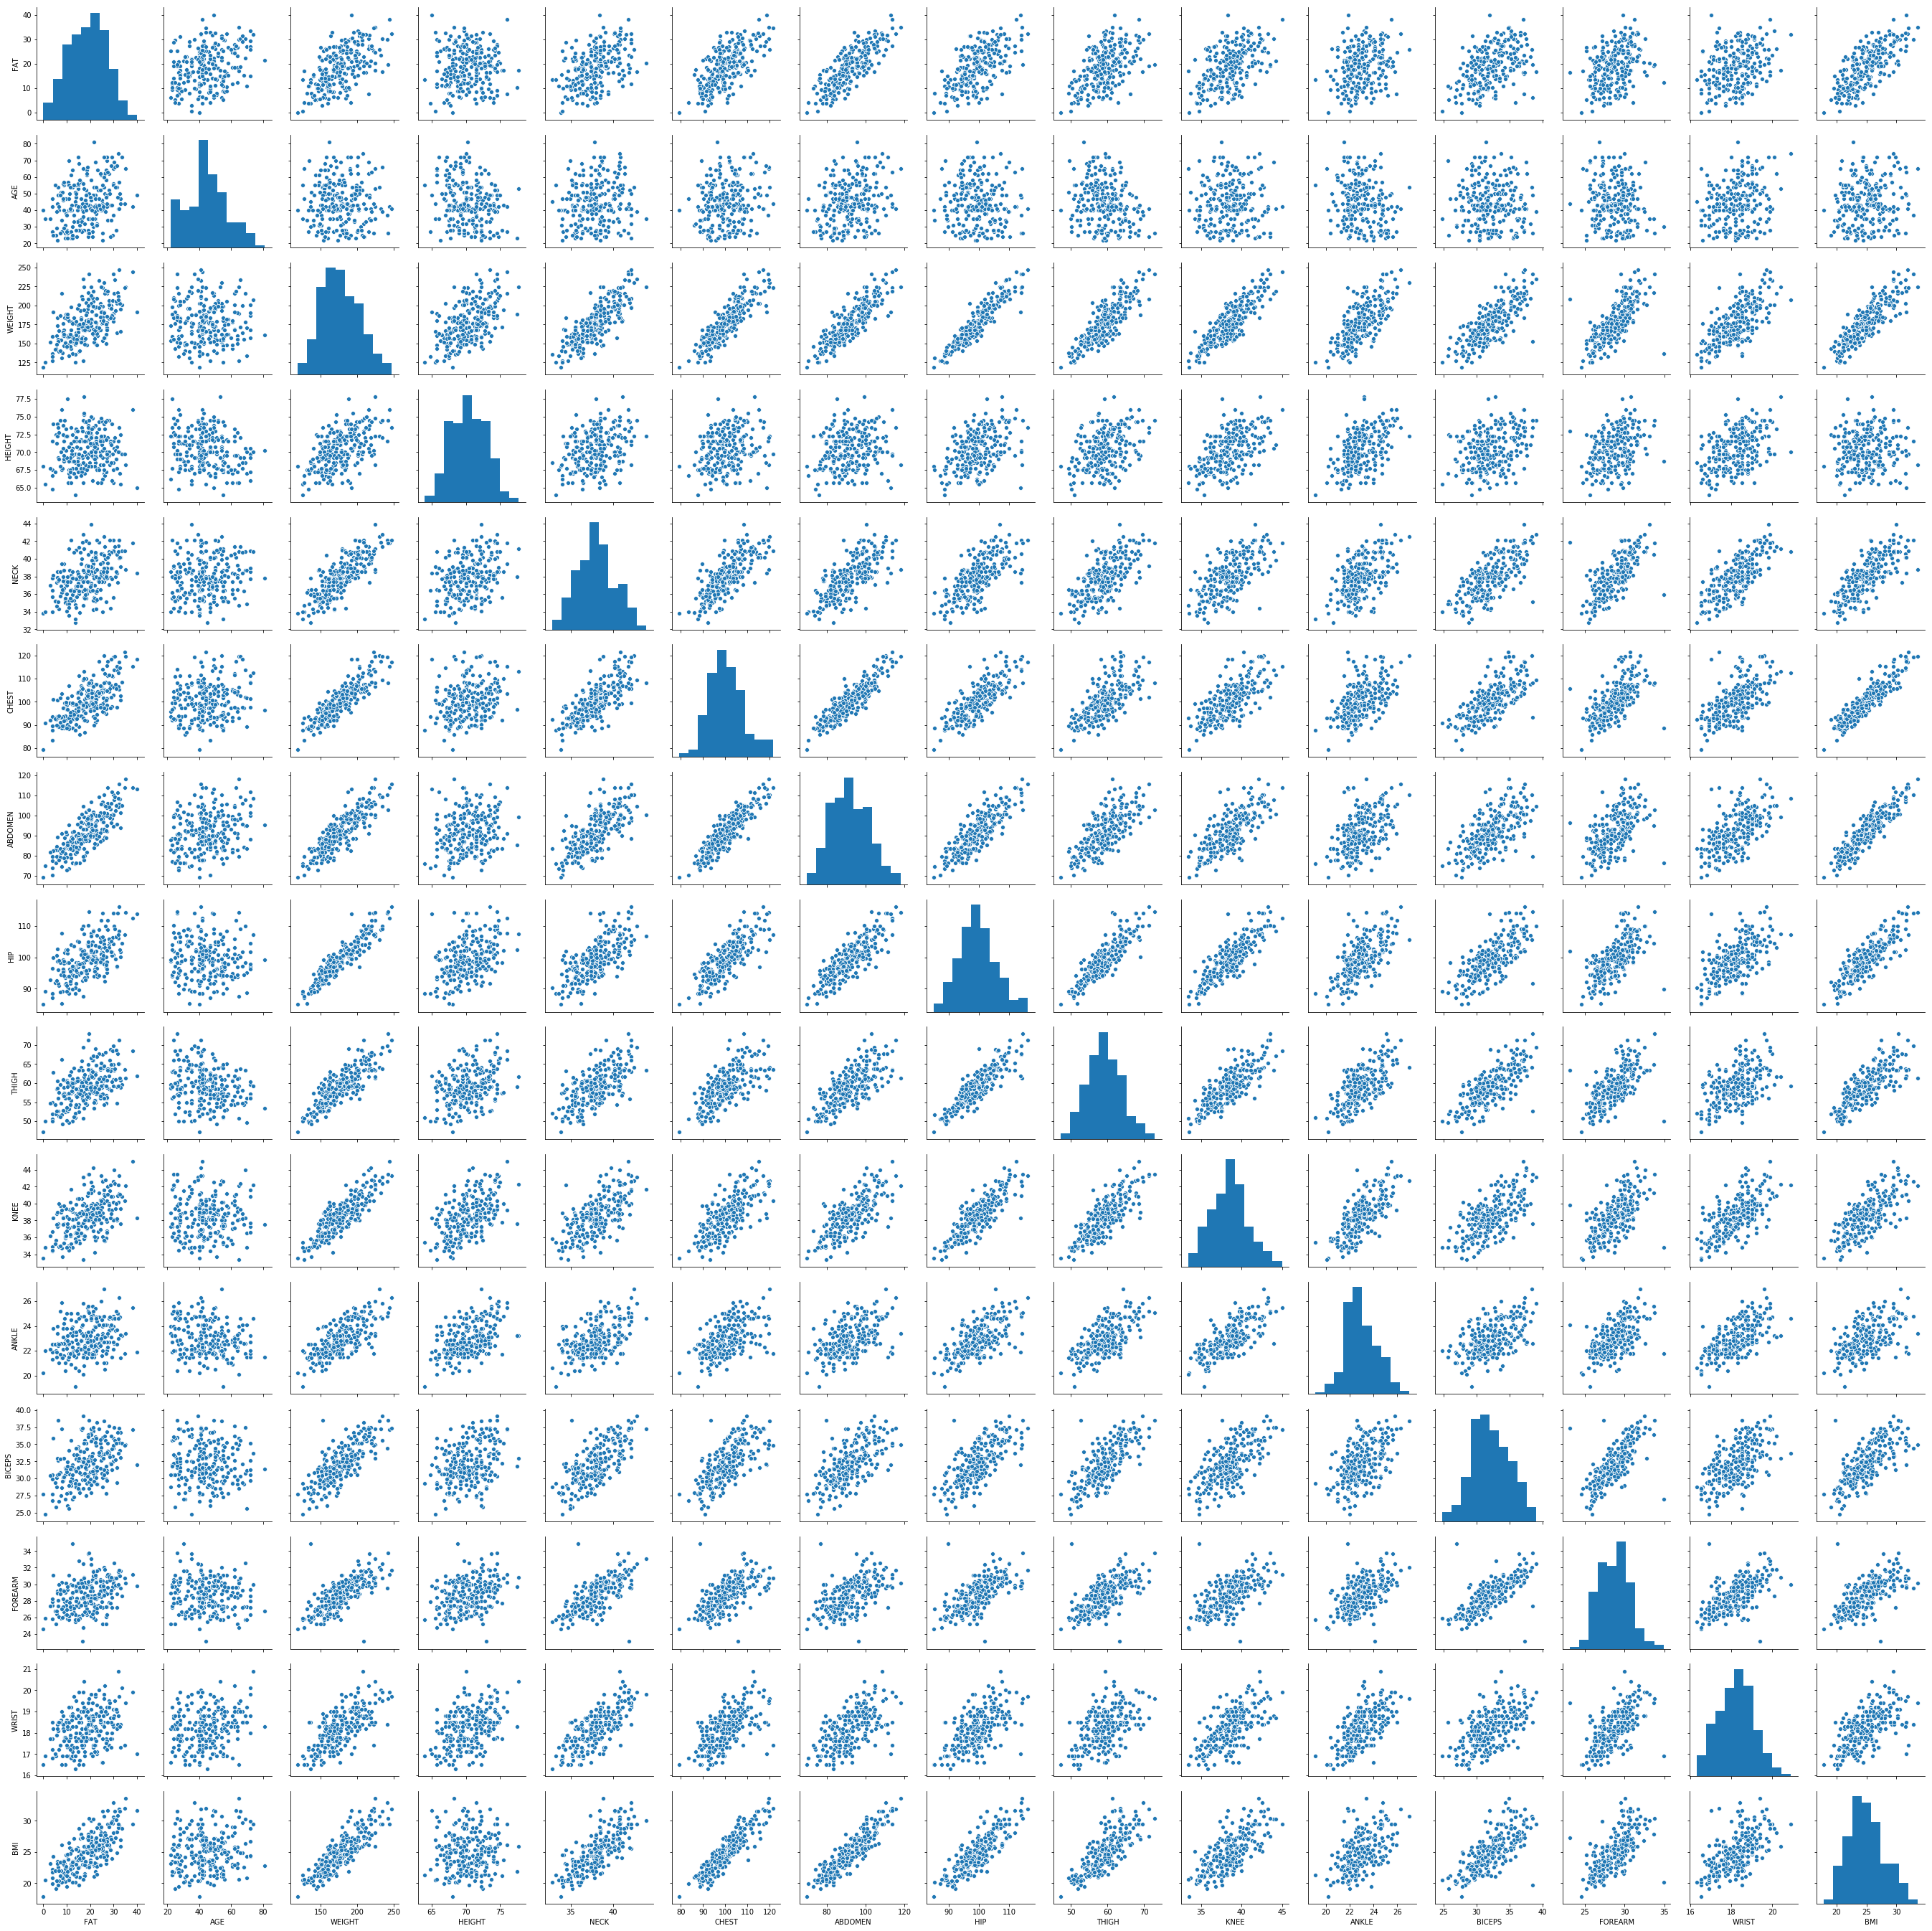

In [39]:
sns.pairplot(ds_fa)
#2,5,6,7,8,9,11,14번째 변수의 양의 상관관계 확인
#그러나 변수끼리 특히 2,14번 째 변수의 타 변수간 다중공선성이 매우 강하게 의심

In [40]:
ds_fa.corr().round(3)
#목표변수 FAT에 가장 큰 영향을 주는 요소는 ABDOMEN로 추측되나, 다중공선성 관계가 의심되는 변수가 많음
#BMI, WEIGHT, HIP과도 상관관계가 유의미해 보임

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
FAT,1.000,0.296,0.593,0.002,0.466,0.678,0.811,0.608,0.528,0.500,0.264,0.460,0.368,0.305,0.720
AGE,0.296,1.000,-0.017,-0.243,0.130,0.193,0.260,-0.061,-0.223,0.011,-0.172,-0.045,-0.098,0.240,0.132
WEIGHT,0.593,-0.017,1.000,0.555,0.802,0.878,0.861,0.925,0.839,0.859,0.710,0.775,0.725,0.699,0.860
HEIGHT,0.002,-0.243,0.555,1.000,0.335,0.252,0.224,0.445,0.370,0.510,0.502,0.324,0.348,0.414,0.057
NECK,0.466,0.130,0.802,0.335,1.000,0.752,0.716,0.686,0.644,0.654,0.540,0.696,0.707,0.731,0.754
CHEST,0.678,0.193,0.878,0.252,0.752,1.000,0.898,0.798,0.678,0.711,0.532,0.694,0.638,0.615,0.904
ABDOMEN,0.811,0.260,0.861,0.224,0.716,0.898,1.000,0.842,0.713,0.732,0.491,0.642,0.557,0.573,0.901
HIP,0.608,-0.061,0.925,0.445,0.686,0.798,0.842,1.000,0.875,0.840,0.639,0.712,0.648,0.583,0.842
THIGH,0.528,-0.223,0.839,0.370,0.644,0.678,0.713,0.875,1.000,0.790,0.654,0.734,0.638,0.504,0.780
KNEE,0.500,0.011,0.859,0.510,0.654,0.711,0.732,0.840,0.790,1.000,0.726,0.644,0.616,0.645,0.719


# 모든 변수 다중 선형 회귀

In [41]:
reg_multi_model=sm.OLS(ds_fa_y,ds_fa_x_const)
reg_multi_results=reg_multi_model.fit()
print(reg_multi_results.summary())
#240개의 관측치, 변수(상수항포함)는 15개, 모델의 자유도는 14
#p값이 0.05보다 작으므로 회귀모델로 유의
#수정설명계수가 0.716으로 낮지 않은 편
#그러나 설명변수들의 p값이 상당 수 매우 높아 회귀계수로서 유의하지 않음
#이에 따라 적절한 변수 제거나 선택이 필요

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     44.01
Date:                Thu, 14 Feb 2019   Prob (F-statistic):           2.01e-56
Time:                        09:03:06   Log-Likelihood:                -681.12
No. Observations:                 240   AIC:                             1392.
Df Residuals:                     225   BIC:                             1444.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -106.9121     62.273     -1.717      0.0

In [45]:
ds_vif=pd.DataFrame()
ds_vif["variable"]=ds_fa_x_const.columns
ds_vif["VIF"]=[variance_inflation_factor(ds_fa_x_const.values,i) for i in range(ds_fa_x_const.shape[1])]
ds_vif.sort_values("VIF",inplace=True)
ds_vif.round(3)
#전체 설명변수를 대상으로 다중공선성 검토
#5,6,7,3,14,2번째 변수들의 VIF가 10 이상이므로 다중공선성을 고려해야함
#WEIGHT나 BMI중 하나를 빼도 큰 영향이 없으면 모델에서 제외
#BMI가 WEIGHT로 부터 파생된 파생변수이므로 최소 둘 중 하나 제거가 더 좋을 것으로 예상

,variable,VIF
1,AGE,2.389
12,FOREARM,2.934
10,ANKLE,3.039
11,BICEPS,3.386
13,WRIST,3.512
4,NECK,4.158
9,KNEE,5.180
8,THIGH,6.940
5,CHEST,10.071
6,ABDOMEN,10.816


In [46]:
model=LinearRegression()
rfe=RFE(estimator=model, n_features_to_select=5).fit(ds_fa_x,ds_fa_y)
selected_cols=ds_fa_x.columns[rfe.support_]
removed_cols=ds_fa_x.columns[~rfe.support_]
print("Selected Variables:{}".format(selected_cols))
print("Removed Variables:{}".format(removed_cols))
#후진제거법에 의해 선택 변수/제거 변수 확인
#5개까지만 변수를 선택하므로 가장 영향력이 큰 5개의 변수만 남김
#모든 변수를 다 넣은 상태에서 영향력이 상대적으로 적은 변수들을 제거
#그러나 WEIGHT와 BMI가 모두 선택됐으므로 둘 중 하나 제거를 위해 변수 4개 선택을 고려

Selected Variables:Index(['WEIGHT', 'HEIGHT', 'ABDOMEN', 'WRIST', 'BMI'], dtype='object')
Removed Variables:Index(['AGE', 'NECK', 'CHEST', 'HIP', 'THIGH', 'KNEE', 'ANKLE', 'BICEPS',
       'FOREARM'],
      dtype='object')


In [47]:
model=LinearRegression()
rfe=RFE(estimator=model, n_features_to_select=4).fit(ds_fa_x,ds_fa_y)
selected_cols=ds_fa_x.columns[rfe.support_]
removed_cols=ds_fa_x.columns[~rfe.support_]
print("Selected Variables:{}".format(selected_cols))
print("Removed Variables:{}".format(removed_cols))
#최종적으로 선택된 4개의 변수는 'HEIGHT', 'ABDOMEN', 'WRIST', 'BMI'
#BMI와 HEIGHT의 관계도 파생변수 관계이므로 다중공선성이 발생할 것이라 예상

Selected Variables:Index(['HEIGHT', 'ABDOMEN', 'WRIST', 'BMI'], dtype='object')
Removed Variables:Index(['AGE', 'WEIGHT', 'NECK', 'CHEST', 'HIP', 'THIGH', 'KNEE', 'ANKLE',
       'BICEPS', 'FOREARM'],
      dtype='object')


In [48]:
ds_fa_x_rfe=sm.add_constant(ds_fa_x_const[selected_cols])
reg_multi_rfe_model=sm.OLS(ds_fa_y,ds_fa_x_rfe)
reg_multi_rfe_results=reg_multi_rfe_model.fit()
print(reg_multi_rfe_results.summary())
#관측치 240개, 변수5개(상수항포함), 모델의 자유도는 4
#F(ANOVA)의 p값이 0.05보다 작으므로 회귀모델로 유의
#기존 모든 선택변수로 돌린 모델보다 설명계수는 0.716에서 0.709로 소폭 감소
#그러나 선택된 4개의 변수 중 BMI만 p값이 0.157이므로 유의하지 않음

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     146.6
Date:                Thu, 14 Feb 2019   Prob (F-statistic):           1.14e-62
Time:                        09:04:43   Log-Likelihood:                -689.16
No. Observations:                 240   AIC:                             1388.
Df Residuals:                     235   BIC:                             1406.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8177      8.283      0.944      0.3

In [49]:
model=LinearRegression()
rfe=RFE(estimator=model, n_features_to_select=3).fit(ds_fa_x,ds_fa_y)
selected_cols=ds_fa_x.columns[rfe.support_]
removed_cols=ds_fa_x.columns[~rfe.support_]
print("Selected Variables:{}".format(selected_cols))
print("Removed Variables:{}".format(removed_cols))
#최종적으로 선택된 3개의 변수는 'HEIGHT', 'ABDOMEN', 'WRIST',

Selected Variables:Index(['HEIGHT', 'ABDOMEN', 'WRIST'], dtype='object')
Removed Variables:Index(['AGE', 'WEIGHT', 'NECK', 'CHEST', 'HIP', 'THIGH', 'KNEE', 'ANKLE',
       'BICEPS', 'FOREARM', 'BMI'],
      dtype='object')


In [50]:
ds_fa_x_rfe=sm.add_constant(ds_fa_x_const[selected_cols])
reg_multi_rfe_model=sm.OLS(ds_fa_y,ds_fa_x_rfe)
reg_multi_rfe_results=reg_multi_rfe_model.fit()
print(reg_multi_rfe_results.summary())
#관측치 240개, 변수 4개(상수항포함), 모델의 자유도는 3
#F(ANOVA)의 p값이 0.05보다 작으므로 회귀모델로 유의
#기존 변수 4개로 돌린 모델보다 설명계수는 0.709에서 0.708로 차이 거의 없음
#선택된 모든 변수들의 p값이 모두 0.05이하이므로 유의하고 이를 사용해 회귀식 도출 가능
#모든 선택된 설명변수들이 유의
#따라서 Y=5.8428-0.4147*HEIGHT+0.7874*ABDOMEN-1.6633*WRIST 라고 회귀식 도출

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     194.0
Date:                Thu, 14 Feb 2019   Prob (F-statistic):           2.05e-63
Time:                        09:04:45   Log-Likelihood:                -690.18
No. Observations:                 240   AIC:                             1388.
Df Residuals:                     236   BIC:                             1402.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8428      8.183      0.714      0.4

In [51]:
ds_rfe_vif=pd.DataFrame()
ds_rfe_vif["variable"]=ds_fa_x_rfe.columns
ds_rfe_vif["VIF"]=[variance_inflation_factor(ds_fa_x_rfe.values,i) for i in range(ds_fa_x_rfe.shape[1])]
ds_rfe_vif.sort_values("VIF",inplace=True)
ds_rfe_vif.round(3)
#다중공선성을 검토한 결과 모든 설명변수(3개)가 VIF가 10을 넘지 않음
#따라서 다중공선성을 특별히 검토하지 않음

,variable,VIF
1,HEIGHT,1.207
2,ABDOMEN,1.490
3,WRIST,1.708
0,const,857.669


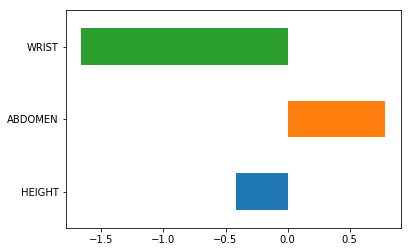

In [52]:
ds_reg_coef=pd.DataFrame({"Coef":reg_multi_rfe_results.params.values[1:]}, index=reg_multi_rfe_model.exog_names[1:])
ds_reg_coef.plot.barh(y="Coef", legend=False)
#표준화 적용 이전의 설명변수 중요도
#단순 계수 분석으로 WRIST가 높은 것으로 나타남
#WRIST가 작을수록 FAT이 큰 결과, 현실적으로 비합리적 설명
#scale을 고려하지 않아 이에 따른 처리 필요

In [53]:
reg_multi_rfe_results.params
#표준화 회귀계수

const      5.842804
HEIGHT    -0.414713
ABDOMEN    0.787421
WRIST     -1.663269
dtype: float64

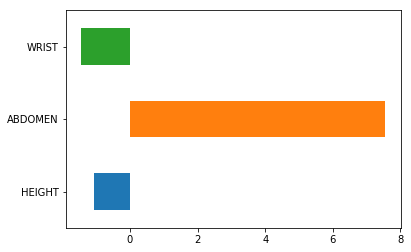

In [54]:
ds_fa_x_scaled=scale(ds_fa_x_const[selected_cols])
ds_fa_x_scaled=sm.add_constant(ds_fa_x_scaled)
reg_multi_scaled_model=sm.OLS(ds_fa_y,ds_fa_x_scaled)
reg_multi_scaled_results=reg_multi_scaled_model.fit()
ds_reg_scaled_coef=pd.DataFrame({"Coef":reg_multi_scaled_results.params.values[1:]},
                               index=reg_multi_rfe_model.exog_names[1:])
ds_reg_scaled_coef.plot.barh(y="Coef",legend=False)
#scale로 데이터 표준화(평균=0, 표준편차=1) 시킴
#회귀계수의 방향은 유지하나 크기가 변함
#표준화 이전과 비교해 ABDOMEN이 가장 중요한 변수이고 실제로도 가장 중요한 변수
#실제 회귀계수의 크기와 관계 없이 ABDOMEN, WRIST, HEIGHT 순으로 영향력이 크고 중요
#ABDOMEN은 복부로 비만에 상당한 영향이 있는 것이 과학적으로 상식적으로 타당하고 합리적

#그러나 WRIST, 손목은 비만인 사람이 거의 모든 부위의 신체사이즈가 커야 할 것으로 생각되는데, 상식에 반함
#HEIGHT는 독립적인 변수라 생각되는데 BMI의 계산에 의해서 잘못 선택된 변수라 볼 수도 있음
#상식적으로 HEIGHT보다는 WEIGHT가 더 직접 영향을 줄 것이라고 판단하나 BMI 파생 등에 의해

#비만인 사람이 대체로 손목이 얇고, 키가 작은 경향이 있을 것인가? 반대로 손목이 얇고 키가 작으면 비만인가?
#경험적으로 볼 수도 있으나 과학적 뚜렷한 근거가 부족
#해당 논문이나 의학적 통계 자료의 접근 등의 추가적인 조사 필요
#2개 변수의 선택이 잘못 될 수 있음
#그래서 WEIGHT나 다른 변수들을 고려

In [55]:
reg_multi_scaled_results.params
#표준화 회귀계수

const    18.779167
x1       -1.074958
x2        7.554680
x3       -1.446778
dtype: float64

In [56]:
def remove_outlier_std(df):

    for i in range(0, len(df.iloc[1])):

        df = df[(np.abs(df.iloc[:,i] - df.iloc[:,i].mean()) < (3.2*df.iloc[:,i].std()))]

    return df

#3.2sigma를 벗어나는 data제거 함수

In [57]:
ds_fa_3z=remove_outlier_std(ds_fa_ori)
ds_fa_3z.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 1 to 251
Data columns (total 15 columns):
FAT        243 non-null float64
AGE        243 non-null int64
WEIGHT     243 non-null float64
HEIGHT     243 non-null float64
NECK       243 non-null float64
CHEST      243 non-null float64
ABDOMEN    243 non-null float64
HIP        243 non-null float64
THIGH      243 non-null float64
KNEE       243 non-null float64
ANKLE      243 non-null float64
BICEPS     243 non-null float64
FOREARM    243 non-null float64
WRIST      243 non-null float64
BMI        243 non-null float64
dtypes: float64(14), int64(1)
memory usage: 30.4 KB


In [58]:
ds_scale_3z=scale(ds_fa_3z)
ds_scale_3z=pd.DataFrame(ds_scale_3z,columns=ds_fa_3z.columns)
ds_scale_3z.head()
ds_scale_describe_3z=ds_scale_3z.describe()
ds_scale_describe_3z.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
count,243.000,243.000,243.000,243.000,243.000,243.000,243.000,243.000,243.000,243.000,243.000,243.000,243.000,243.000,243.000
mean,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000
std,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002
min,-2.339,-1.806,-2.258,-2.451,-3.036,-2.702,-2.321,-2.374,-2.498,-2.275,-2.961,-2.554,-2.911,-2.399,-2.296
25%,-0.796,-0.773,-0.739,-0.757,-0.693,-0.807,-0.772,-0.657,-0.662,-0.696,-0.742,-0.688,-0.730,-0.688,-0.688
50%,0.038,-0.137,-0.054,-0.128,-0.001,-0.103,-0.108,-0.041,-0.057,-0.051,-0.206,-0.100,-0.003,0.111,-0.089
75%,0.754,0.737,0.708,0.743,0.668,0.608,0.710,0.591,0.610,0.595,0.712,0.660,0.672,0.681,0.655
max,2.651,2.882,2.677,2.871,2.676,2.714,2.681,2.735,3.175,2.886,3.084,2.387,3.216,3.077,2.800


In [59]:
ds_scale_3z.corr().round(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
FAT,1.000,0.288,0.604,0.005,0.469,0.685,0.816,0.618,0.543,0.507,0.272,0.471,0.384,0.316,0.728
AGE,0.288,1.000,-0.019,-0.239,0.128,0.188,0.250,-0.063,-0.222,0.011,-0.171,-0.044,-0.095,0.239,0.124
WEIGHT,0.604,-0.019,1.000,0.550,0.796,0.882,0.865,0.928,0.843,0.860,0.707,0.781,0.733,0.702,0.864
HEIGHT,0.005,-0.239,0.550,1.000,0.339,0.255,0.224,0.442,0.363,0.509,0.496,0.326,0.347,0.413,0.059
NECK,0.469,0.128,0.796,0.339,1.000,0.754,0.712,0.685,0.648,0.645,0.517,0.696,0.701,0.715,0.745
CHEST,0.685,0.188,0.882,0.255,0.754,1.000,0.900,0.804,0.689,0.713,0.530,0.702,0.647,0.618,0.905
ABDOMEN,0.816,0.250,0.865,0.224,0.712,0.900,1.000,0.847,0.726,0.733,0.493,0.650,0.569,0.576,0.905
HIP,0.618,-0.063,0.928,0.442,0.685,0.804,0.847,1.000,0.878,0.841,0.638,0.719,0.657,0.588,0.847
THIGH,0.543,-0.222,0.843,0.363,0.648,0.689,0.726,0.878,1.000,0.785,0.644,0.738,0.647,0.507,0.789
KNEE,0.507,0.011,0.860,0.509,0.645,0.713,0.733,0.841,0.785,1.000,0.728,0.650,0.624,0.651,0.721


# WRIST, HEIGHT, WEIGHT와 FAT: 회귀계수 음수

# #원본 data에 상관계수가 높은 BMI, HIP 추가 등을 해보며 변수를 빼기도 함
# 3z로 이상치를 제거하고

# ABDOMEN, HEIGHT, WRIST를 채택했을 경우 3개의 설명변수로 0.713의 설명력을 보임
# ABDOMEN, WEIGHT, WRIST의 경우 0.714고 상수의 p값도 유의 //


# 이상치 제거와 HEIGHT의 제거로 다소 설명력이 오름

# 하지만 WEIGHT, WRIST의 회귀계수가 음수인 것을 쉽게 설명이 불가


# 비만이여도 WRIST는 크게 증가하지 않고, 운동을 한 건강한 사람이 WRIST가 큼
# WRIST에는 다른 부위보다 쉽게 제한, 엄청 크게 증가하지 못함
# 오히려 손목둘레가 감소해야 비만이라는 상식과 다소 다른 결과
# 하지만 비만인 사람들이 특정 부위에 대해서 신체특성상 더 얇을 수도 있음(근육 비중이 적고, 지방 비중이 높음)

# WEIGHT도 계수가 음수이긴 하지만 0에 매우 가깝고
# 단순 WEIGHT만으로 비만을 판정할 수 없음

# 추가적인 해당 변수에대한 조사, 이상치의 면밀한 검토
# WRIST를 크게 하는 유전자 보유자는 비만에 덜 걸린다는 식의 논문, 의학적 자료 등이 제공돼
# 해당 변수들에 대한 현실적이고 과학적인 설명이 필요함

# 해당 모델에 의하면 손목이 얇을 수록, 무게가 낮을수록 비만
# 현실적으로 맞지 않는 답변을 할 수가 있음
# 해당 인과 관계를 논리적, 과학적으로 설명할 추가 근거가 있다면 
# 해당 변수들의 방향성을 이용해 예측모델로 사용

# 단순 선형관계를 가정했기에 실제로는 비선형, 다중공선성 등에 의해 일부 왜곡
# 추가적인 파생변수나 변수 scale 변화 등을 고려하면 더 나은 모델이 나올 수 있음

# 단순 수치 예측이 필요하다면 참고할 정도로 사용이 가능할 것으로 생각
# 조사한 data들의 특정 경향성을 오히려 나타낼 수도 있음(WEIGHT, WRIST 낮은 비만)


# 최종 도출 회귀식 : FAT=-29.0810-0.0903*HEIGHT+0.9523*ABDOMEN-1.3005*WRIST 

In [95]:
formula_model=smf.ols(formula="FAT~ ABDOMEN+WRIST+WEIGHT",data=ds_fa_3z)
formula_result=formula_model.fit()
print(formula_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     202.7
Date:                Thu, 14 Feb 2019   Prob (F-statistic):           2.22e-65
Time:                        09:35:09   Log-Likelihood:                -697.44
No. Observations:                 243   AIC:                             1403.
Df Residuals:                     239   BIC:                             1417.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -29.0810      6.955     -4.181      0.0

In [65]:
ds_fa_3z_y=ds_fa_3z["FAT"]
ds_fa_3z_x=ds_fa_3z.drop("FAT", axis=1, inplace=False)
print("목표변수 데이터 크기:{}".format(ds_fa_3z_y.shape))
print("설명변수 데이터 크기:{}".format(ds_fa_3z_x.shape))
#관측치 240개, 설명변수 14개(BMI포함), 목표변수 FAT 

목표변수 데이터 크기:(243,)
설명변수 데이터 크기:(243, 14)


In [66]:
ds_fa_3z_x_const=sm.add_constant(ds_fa_3z_x)
ds_fa_3z_x_const.head()
#회귀분석을 위한 절편 생성

,const,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
1,1.0,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.082595
2,1.0,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.422478
3,1.0,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.838617
5,1.0,40,202.25,70.00,38.5,106.5,100.9,106.2,63.5,39.9,22.6,35.1,30.6,19.0,28.789726
6,1.0,52,167.00,67.75,37.5,102.7,91.0,98.9,57.1,36.7,22.3,31.6,27.5,17.9,25.377156


In [73]:
model_3z=LinearRegression()
rfe_3z=RFE(estimator=model_3z, n_features_to_select=3).fit(ds_fa_3z_x,ds_fa_3z_y)
selected_3z_cols=ds_fa_3z_x.columns[rfe_3z.support_]
removed_3z_cols=ds_fa_3z_x.columns[~rfe_3z.support_]
print("Selected Variables:{}".format(selected_3z_cols))
print("Removed Variables:{}".format(removed_3z_cols))
#후진제거 변수 3개 선택에 의해서는 WEIGHT가 아닌 HEIGHT가 선택됨. 큰 차이는 없으나 WEIGHT가 미미하게 좋음

Selected Variables:Index(['HEIGHT', 'ABDOMEN', 'WRIST'], dtype='object')
Removed Variables:Index(['AGE', 'WEIGHT', 'NECK', 'CHEST', 'HIP', 'THIGH', 'KNEE', 'ANKLE',
       'BICEPS', 'FOREARM', 'BMI'],
      dtype='object')


In [74]:
ds_fa_3z_x_rfe=sm.add_constant(ds_fa_3z_x_const[selected_3z_cols])
reg_multi_rfe_3z_model=sm.OLS(ds_fa_3z_y,ds_fa_3z_x_rfe)
reg_multi_rfe_3z_results=reg_multi_rfe_3z_model.fit()
print(reg_multi_rfe_3z_results.summary())
#관측치 243개, 변수 4개(상수항포함), 모델의 자유도는 3
#F(ANOVA)의 p값이 0.05보다 작으므로 회귀모델로 유의
#수정설명계수는 0.713
#선택된 모든 변수들의 p값이 모두 0.05이하이므로 유의하고 이를 사용해 회귀식 도출 가능
#모든 선택된 설명변수들이 유의
#따라서 FAT=5.2485-0.4183*HEIGHT+0.7826*ABDOMEN-1.5932*WRIST 라고 회귀식 도출
#기존 WEIGHT모델과 큰 차이는 없음

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     201.4
Date:                Thu, 14 Feb 2019   Prob (F-statistic):           3.83e-65
Time:                        09:21:56   Log-Likelihood:                -697.99
No. Observations:                 243   AIC:                             1404.
Df Residuals:                     239   BIC:                             1418.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2485      8.107      0.647      0.5

In [99]:
ds_vif_x=pd.DataFrame()
ds_vif_x["WEIGHT"]=ds_fa_3z["WEIGHT"]
ds_vif_x["ABDOMEN"]=ds_fa_3z["ABDOMEN"]
ds_vif_x["WRIST"]=ds_fa_3z["WRIST"]
ds_vif_x=sm.add_constant(ds_vif_x)

In [100]:
ds_vif=pd.DataFrame()
ds_vif["variable"]=ds_vif_x.columns
ds_vif["VIF"]=[variance_inflation_factor(ds_vif_x.values,i) for i in range(ds_vif_x.shape[1])]
ds_vif.sort_values("VIF",inplace=True)
ds_vif.round(3)
#다중공선성을 검토한 결과 모든 설명변수(3개)가 VIF가 10을 넘지 않음
#따라서 다중공선성을 특별히 검토하지 않음

,variable,VIF
3,WRIST,1.986
2,ABDOMEN,4.008
1,WEIGHT,5.276
0,const,634.583


# 회귀의 기본 가정 검토

In [103]:
ds_fa_3z_y=ds_fa_3z["FAT"]
ds_fa_3z_x=pd.DataFrame()
ds_fa_3z_x["ABDOMEN"]=ds_fa_3z["ABDOMEN"]
ds_fa_3z_x["WRIST"]=ds_fa_3z["WRIST"]
ds_fa_3z_x["WEIGHT"]=ds_fa_3z["WEIGHT"]

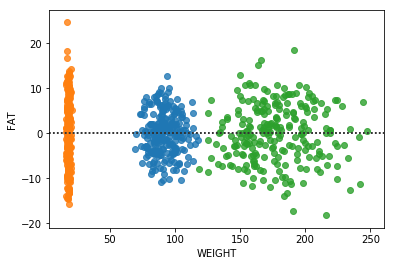

In [104]:
for i in list(ds_fa_3z_x.columns):
    sns.residplot(ds_fa_3z_x[i],ds_fa_3z_y)
#잔차 산점도
#잔차=실측-예측 예측이 어느 정도 바운더리를 형성

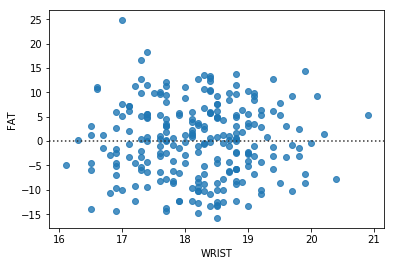

In [105]:
ds_fa_3z_x_WRIST=ds_fa_3z_x["WRIST"]
ds_fa_3z_x_AMDOMEN=ds_fa_3z_x["ABDOMEN"]
ds_fa_3z_x_WEIGHT=ds_fa_3z_x["WEIGHT"]
sns.residplot(ds_fa_3z_x_WRIST,ds_fa_3z_y)
#WRIST 잔차가 일부 +로 큰 부분이 있지만 등분산성을 어느 정도 보인다

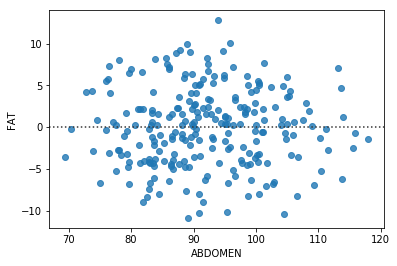

In [106]:
sns.residplot(ds_fa_3z_x_AMDOMEN,ds_fa_3z_y)
#ABDOMEN 잔차가 등분산성을 보인다

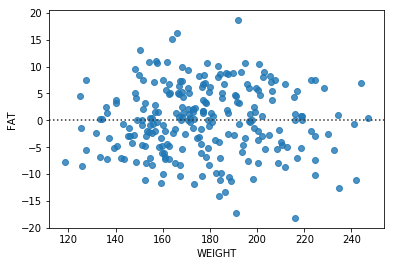

In [107]:
sns.residplot(ds_fa_3z_x_WEIGHT,ds_fa_3z_y)
#WEIGHT 잔차가 등분산성을 어느 정도 보인다

((array([-2.76474183, -2.4617275 , -2.28959033, -2.1666286 , -2.06969096,
         -1.98901632, -1.91952828, -1.85823521, -1.80321964, -1.75317579,
         -1.70717277, -1.66452252, -1.62470157, -1.58730196, -1.55199935,
         -1.51853141, -1.48668284, -1.45627467, -1.42715642, -1.39920031,
         -1.3722969 , -1.34635164, -1.32128232, -1.29701694, -1.27349212,
         -1.25065171, -1.22844575, -1.20682956, -1.18576302, -1.16520998,
         -1.14513771, -1.12551651, -1.10631932, -1.08752141, -1.06910013,
         -1.05103468, -1.0333059 , -1.01589608, -0.99878886, -0.98196905,
         -0.96542257, -0.94913627, -0.93309791, -0.91729605, -0.90171998,
         -0.88635967, -0.87120569, -0.85624918, -0.84148181, -0.8268957 ,
         -0.81248343, -0.79823799, -0.78415272, -0.77022133, -0.75643785,
         -0.7427966 , -0.7292922 , -0.71591951, -0.70267364, -0.68954993,
         -0.67654391, -0.66365135, -0.65086817, -0.63819047, -0.62561452,
         -0.61313676, -0.60075373, -0.

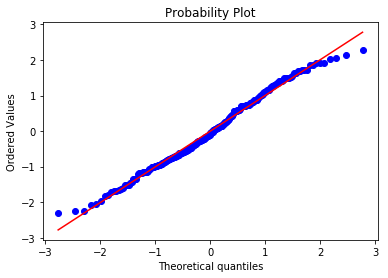

In [108]:
res=reg_multi_rfe_3z_results.resid
z=(res-np.mean(res))/np.std(res)
stats.probplot(z, dist="norm", plot=plt)
#일부 정규성을 벗어나는 data가 있으나 대부분 정규성을 만족한다고 볼 수 있음